In [1]:
import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import seaborn as sns

from kaggle_environments import make, evaluate

termcolor not installed, skipping dependency
No pygame installed, ignoring import


/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


В настоящей работе реализованы 13 различных агентов:
- `rock_agent` - всегда выбрасывает камень;
- `paper_agent` - всегда выбрасывает бумагу;
- `scissors_agent` - всегда выбрасывает ножницы;
- `sequence_agent` - всегда совершает ходы в прямой последовательности (камень - бумага - ножницы - ...);
- `reverse_sequence_agent` - всегда совершает ходы в обратной последовательности (ножницы - бумага - камень - ...);
- `three_double_agent` - совершает по три одинаковых хода в прямой последовательности (000-111-222-...);
- `random_agent` - совершает действия в случайном порядке;
- `rock_first_agent` - самым первым ходом всегда выбрасывает камень, затем ходит случайным образом;
- `copy_opponent_agent` - копирует предыдущее действие своего оппонента;
- `last_react_win_agent` - совершает действия, побеждающие предыдущие ходы своего оппонента;
- `statistical_agent` - ведет статистику ходов оппонента и совершает действия, парирующие наиболее часто разыгрываемые ходы оппонента;
- `q_learning_agent` - реализовывает алгоритм обучения с подкреплением Q-learning;
- `sarsa_agent` - реализовывает алгоритм обучения с подкреплением SARSA.

In [2]:
%%writefile rock_agent.py
# 1) Агент, всегда бросающий камень  
def rock_agent_act(observation, configuration):
    return 0

Overwriting rock_agent.py


In [3]:
%%writefile paper_agent.py
# 2) Агент, всегда бросающий бумагу
def paper_agent_act(observation, configuration):
    return 1

Overwriting paper_agent.py


In [4]:
%%writefile scissors_agent.py
# 3) Агент, всегда бросающий ножницы
def scissors_agent_act(observation, configuration):
    return 2

Overwriting scissors_agent.py


In [5]:
%%writefile sequence_agent.py
# 4) Агент, выбрасывающий элементы в прямой последовательности (0, 1, 2)
class SequenceAgent:
    def __init__(self):
        self.action = 0 # начальное состояние

# Инициализируем экземпляр класса агента и метод его действия
agent = SequenceAgent()
def act(observation, configuration):
    if agent.action == 0:
        agent.action = 1
    elif agent.action == 1:
        agent.action = 2
    elif agent.action == 2:
        agent.action = 0
    return agent.action

Overwriting sequence_agent.py


In [6]:
%%writefile reverse_sequence_agent.py
# 5) Агент, выбрасывающий элементы в обратной последовательности (2, 1, 0)
class ReverseSequenceAgent:
    def __init__(self):
        self.action = 2 # начальное состояние

# Инициализируем экземпляр класса агента и метод его действия
agent = ReverseSequenceAgent()
def act(observation, configuration):
    if agent.action == 2:
        agent.action = 1
    elif agent.action == 1:
        agent.action = 0
    elif agent.action == 0:
        agent.action = 2
    return agent.action

Overwriting reverse_sequence_agent.py


In [7]:
%%writefile three_double_agent.py
# 6) Агент, повторяющий свой ход 3 раза подряд в прямой последовательности (0, 1, 2)
class ThreeDoubleAgent:
    def __init__(self):
        self.action = 0 # начальное состояние

# Инициализируем экземпляр класса агента и метод его действия
agent = ThreeDoubleAgent()
def act(observation, configuration):
    if observation.step > 0 and observation.step % 3 == 0:
        if agent.action == 0:
            agent.action = 1
        elif agent.action == 1:
            agent.action = 2
        elif agent.action == 2:
            agent.action = 0
    return agent.action

Overwriting three_double_agent.py


In [48]:
%%writefile random_agent.py
import random

# 7) Агент, всегда выбрасывающий случайный элемент
def random_agent_act(observation, configuration):
    return random.randrange(0, configuration.signs)

Overwriting random_agent.py


In [47]:
%%writefile rock_first_agent.py
import random

# 8) Агент, первым ходом всегда выбрасывающий камень, затем случайные элементы   
def rock_first_agent_act(observation, configuration):
    if observation.step == 0:
        return 0
    else:
        return random.randrange(0, configuration.signs)

Overwriting rock_first_agent.py


In [46]:
%%writefile copy_opponent_agent.py
import random

# 9) Агент, копирующий предыдущий ход оппонента
def copy_opponent_agent_act(observation, configuration):
    # Если это не первый ход, выбросить значение предыдущего хода оппонента
    if observation.step > 0:
        return observation.lastOpponentAction
    else:
        # Если это первый ход, выбросить случайный элемент
        return random.randrange(0, configuration.signs)

Overwriting copy_opponent_agent.py


In [12]:
%%writefile last_react_win_agent.py
import random
import math

# 10) Агент, выбрасывающий элемент, побеждающий предыдущий ход оппонента
class LastReactWinAgent():
    def __init__(self):
        self.last_react_action = None

    # Метод для вычисления награды за ход (для агентов, анализирующих действия оппонента без обучения)
    def get_score(self, agent_action, opponent_action):
        # Вычислить разницу между действиями оппонента и агента для определения очков
        delta = (
            opponent_action - agent_action
            if (agent_action + opponent_action) % 2 == 0
            else agent_action - opponent_action
        )
        return 0 if delta == 0 else math.copysign(1, delta)

# Инициализируем экземпляр класса агента и метод его действия
agent = LastReactWinAgent()
def act(observation, configuration):
    # Первый ход совершается случайным образом
    if observation.step == 0:
        agent.last_react_action = random.randrange(0, configuration.signs)
    # Каждый последующий ход агент выбрасывает значение, побеждающее предыдущее действие оппонента
    elif agent.get_score(agent.last_react_action, observation.lastOpponentAction) != 1:
        agent.last_react_action = (agent.last_react_action + 2) % configuration.signs

    return agent.last_react_action

Overwriting last_react_win_agent.py


In [3]:
%%writefile statistical_agent.py
import random

# 11) Агент, анализирующий статистику ходов оппонента
class StatisticalAgent():
    def __init__(self):
        self.action_histogram = {}

# Инициализируем экземпляр класса агента и метод его действия
agent = StatisticalAgent()
def act(observation, configuration):
    if observation.step == 0:
        agent.action_histogram = {}
        return

    # Агент реагирует на каждое предыдущее действие оппонента и записывает его в словарь action_histogram,
    # ключами которого являются действия оппонента, а значениями - количество тех или иных действий
    action = observation.lastOpponentAction
    if action not in agent.action_histogram:
        agent.action_histogram[action] = 0
    agent.action_histogram[action] += 1

    mode_action = None # действие оппонента, совершённое им наибольшее число раз
    mode_action_count = None # наибольшее количество действий оппонента

    for k, v in agent.action_histogram.items():
        if mode_action_count is None or v > mode_action_count:
            mode_action = k
            mode_action_count = v

    return (mode_action + 1) % configuration.signs

Overwriting statistical_agent.py


In [43]:
%%writefile agent.py
import numpy as np
import math

# Базовый класс, от которого наследуются последующие классы-агенты с алгоритмами обучения
class Agent:
    def __init__(self):
       # Инициализация параметров обучения агента
       self.alpha = 0.1 # коэффициент обучения
       self.gamma = 0.9 # коэффициент дисконтирования
       self.epsilon = 0.1 # параметр исследования

       # Инициализация начального состояния и действия агента
       self.state = np.random.randint(0, 3) # 0 - бросок камня, 1 - бросок бумаги, 2 - бросок ножниц
       self.action = np.random.randint(0, 3)
       self.previous_action = None

       # Инициализация Q-таблицы
       # В качестве условия примем, что начальные вероятности равны
       self.Q = np.array([[1/3, 1/3, 1/3], 
                          [1/3, 1/3, 1/3], 
                          [1/3, 1/3, 1/3]])
    
    # Метод для выбора действия агента
    def act(self):
        # Реализация политики агента
        self.previous_action = self.action # сохранить предыдущее действие
        self.action = self._choose_action()
        return int(self.action)
    
    # Метод для обновления текущего состояния агента на основании полученной награды за ход
    def fit(self, state):
        # Вычислить разницу между текущим действием и состоянием среды для определения награды
        delta = (
            state - self.action
            if (self.action + state) % 2 == 0
            else self.action - state
        )
        reward = 0 if delta == 0 else math.copysign(1, delta)

        # Обновить значения на основании полученной награды
        self._learn(reward, state)
        # Обновить текущее состояние агента
        self.state = state
    
    # Метод для обучения агента
    # Переопределяется дочерними классами-агентами с алгоритмами обучения
    def _learn(self, reward, state):
        pass
    
    # Реализация жадного алгоритма, определяющего политику агента
    def _choose_action(self):
        if np.random.random() < self.epsilon:
            return np.random.randint(0, 3) # выбираем случайное действие
        else:
            return np.argmax(self.Q[self.state]) # выбираем максимальное значение в Q-таблице, соответствующее текущему состоянию

Overwriting agent.py


In [42]:
%%writefile q_learning_agent.py
from agent import Agent
import numpy as np

# 12) Агент, обучающийся с помощью алгоритма Q-learning
class QLearningAgent(Agent):
    def __init__(self):
        super().__init__()

    def _learn(self, reward, state):
        # В соответствии с уравнением Беллмана обновляем значения в Q-таблице
        self.Q[self.state][self.action] = (1 - self.alpha) * self.Q[self.state][self.previous_action] \
            + self.alpha * (reward + self.gamma * np.max(self.Q[state]) - self.Q[self.state][self.previous_action])
    
# Инициализируем экземпляр класса агента и метод его действия
agent = QLearningAgent()
def act(observation, configuration):
    # Обновление состояния агента с последующим обучением инициализируем после первого хода
    if observation.step > 0:
        agent.fit(observation.lastOpponentAction)
    return agent.act()

Overwriting q_learning_agent.py


In [41]:
%%writefile sarsa_agent.py
from agent import Agent
import numpy as np

# 13) Агент, обучающийся с помощью алгоритма SARSA
class SarsaAgent(Agent):
    def __init__(self):
        super().__init__()

    def _learn(self, reward, state):
        # В соответствии с формулой SARSA обновляем значения в Q-таблице
        self.Q[self.state][self.action] = self.alpha * (reward + self.gamma * self.Q[state][self.action] \
            - self.Q[self.state][self.previous_action])

# Инициализируем экземпляр класса агента и метод его действия
agent = SarsaAgent()
def act(observation, configuration):
    # Обновление состояния агента с последующим обучением инициализируем после первого хода
    if observation.step > 0:
        agent.fit(observation.lastOpponentAction)
    return agent.act()

Overwriting sarsa_agent.py


Организуем турнир между реализованными агентами. При создании турнирных таблиц учтём, что **одинаковые агенты не могут играть друг с другом**. Для подсчёта очков в раундах воспользуемся функцией `evaluate` из библиотеки **kaggle_environments**. В ходе турнира будем вести двойной подсчёт - как общего числа очков каждого агента, так и числа совершённых ими побед.

In [8]:
# Создаём словарь из экземпляров агентов
agents = {
    "rock": "rock_agent.py",
    "scissors": "scissors_agent.py",
    "paper": "paper_agent.py",
    "sequence": "sequence_agent.py",
    "reverse_sequence": "reverse_sequence_agent.py",
    "three_double": "three_double_agent.py",
    "random": "random_agent.py",
    "rock_first": "rock_first_agent.py",
    "copy_opponent": "copy_opponent_agent.py",
    "last_react_win": "last_react_win_agent.py",
    "statistical": "statistical_agent.py",
    "q_learning": "q_learning_agent.py",
    "sarsa": "sarsa_agent.py"
}

# Инициализируем словари для результатов турнира
tournament_results = {}
tournament_wins = {}
# Инициализируем списки, в котором будут храниться результаты всех игр одного агента
tournament_table_row = []
tournament_wins_table_row = []

for i in agents.values():
    for j in agents.values():
        if i == j:
            round_result = 0 # игры с одинаковыми агентами не учитываются в турнире
        else:
            round_result = int(evaluate("rps", [i, j], configuration={"episodeSteps": 1000, "tieRewardThreshold": 10})[0][0])
        tournament_table_row += [round_result]
        tournament_wins_table_row += [0] if round_result <= 0 else [1]
    tournament_results[i] = tournament_table_row
    tournament_wins[i] = tournament_wins_table_row
    tournament_table_row = [] # очищаем списки для следующего агента
    tournament_wins_table_row = []

In [18]:
# С помощью библиотеки pandas создадим таблицу результатов турнира
tournament_table = pd.DataFrame(tournament_results)
tournament_table.index = agents.keys() # устанавливаем индексы таблицы
tournament_table.columns = agents.keys()
tournament_table = tournament_table.T # транспонируем таблицу

# Дополнительно реализуем таблицу с общим числом побед каждого агента во всём турнире
tournament_wins_table = pd.DataFrame(tournament_wins)
tournament_wins_table.index = agents.keys()
tournament_wins_table.columns = agents.keys()
tournament_wins_table = tournament_wins_table.T

# Отобразим таблицу с помощью градиентной карты
tournament_table.style.background_gradient(cmap="Reds")

,rock,scissors,paper,sequence,reverse_sequence,three_double,random,rock_first,copy_opponent,last_react_win,statistical,q_learning,sarsa
rock,0,999,-999,0,0,0,19,0,0,-999,-998,-875,-908
scissors,-999,0,999,0,0,0,0,0,0,-997,-999,-881,-907
paper,999,-999,0,0,0,0,-11,-59,0,-996,-997,-863,-886
sequence,0,0,0,0,0,0,13,46,998,-500,0,-908,-916
reverse_sequence,0,0,0,0,0,0,-38,0,-999,999,0,-903,-896
three_double,0,0,0,0,0,0,0,0,332,0,0,-511,-535
random,13,0,-55,0,-14,-25,0,-14,-47,14,-16,25,60
rock_first,16,-24,-23,0,-12,10,21,0,0,20,-21,32,-15
copy_opponent,0,0,0,-998,998,-331,0,10,0,999,-201,-35,-39
last_react_win,999,997,997,498,-999,0,0,0,-996,0,599,-813,-707


Для более наглядного отображения наиболее эффективной стратегии построим две гистограммы, на которых отражены:
1. Общее число побед каждого агента в турнире;
2. Общее количество очков каждого агента.

<Axes: xlabel='Агент', ylabel='Количество побед'>

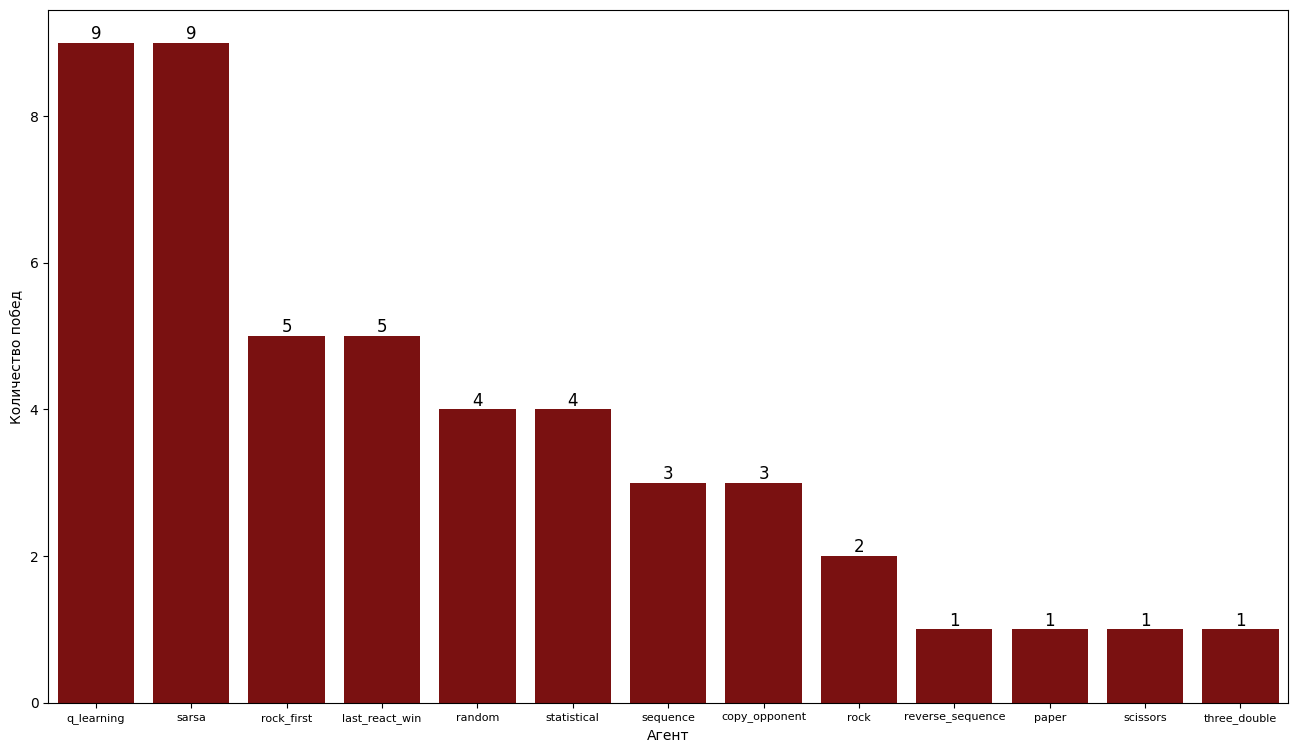

In [19]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize = 8)
tournament_histogram = sns.barplot(tournament_wins_table.sum(axis=1).sort_values(ascending=False), color="darkred")
tournament_histogram.set(xlabel="Агент", ylabel="Количество побед")
tournament_histogram.bar_label(tournament_histogram.containers[0], fontsize=12)
display(tournament_histogram)

<Axes: xlabel='Агент', ylabel='Общее количество очков'>

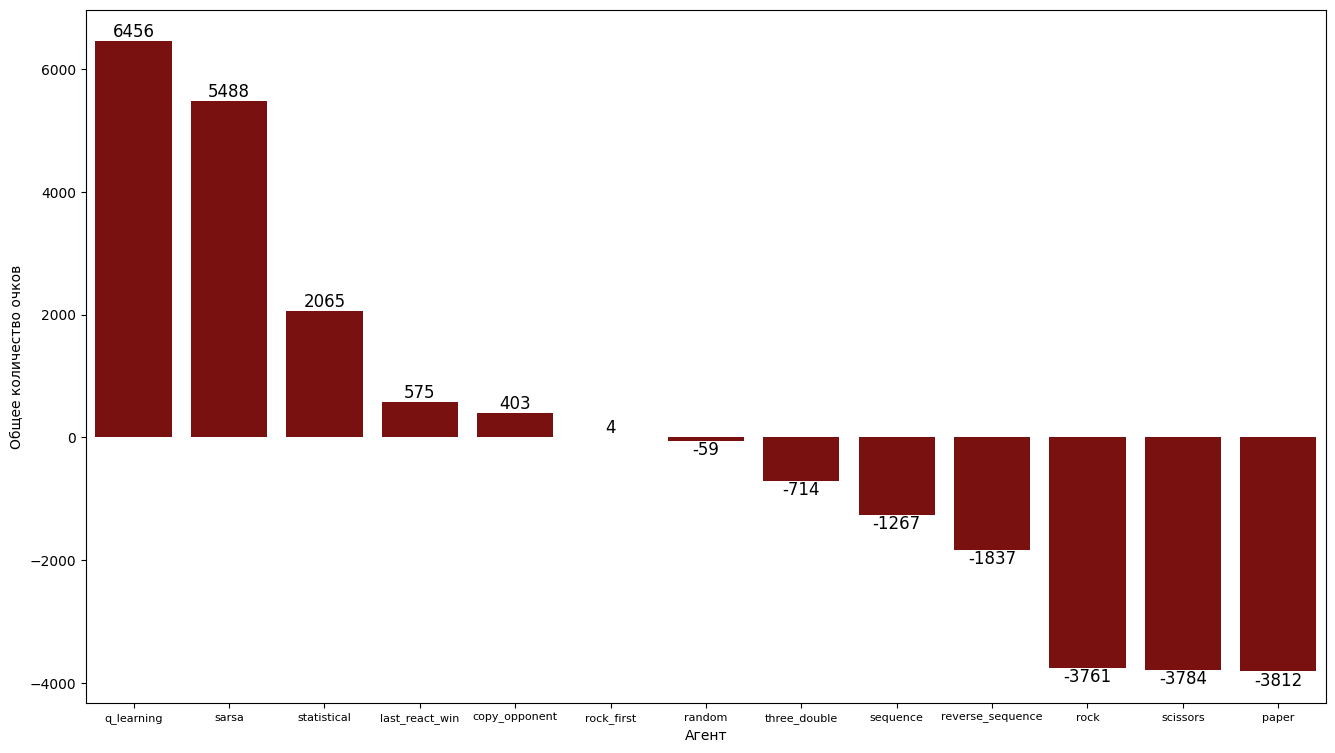

In [12]:
plt.figure(figsize=(16, 9))
plt.xticks(fontsize = 8)
tournament_histogram = sns.barplot(tournament_table.sum(axis=1).sort_values(ascending=False), color="darkred")
tournament_histogram.set(xlabel="Агент", ylabel="Общее количество очков")
tournament_histogram.bar_label(tournament_histogram.containers[0], fontsize=12)
display(tournament_histogram)

По результатам анализа полученных результатов приходим к выводу, что стратегии агентов `q_learning` и `sarsa`, основанные на алгоритмах обучения с подкреплением, оказались наиболее эффективными.